In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'benchmark_lapa',
        root = '..',
        default_wildcards={'sample': 'WTC11'}
    )

In [2]:
from pathlib import Path 
import pandas as pd
import numpy as np
import pyranges as pr
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from lapa.result import LapaResult
from sklearn.metrics import precision_recall_curve, auc

In [3]:
results = dict()

for i in snakemake.input['lapa_dir']:
    library_prep, platform, _ = Path(i).name.split('_')
    results[f'{library_prep} {platform}'] = LapaResult(i, tpm_cutoff=0)

In [4]:
core_cols = ['Chromosome', 'Start', 'End', 'Strand']

In [165]:
result_quantseq = LapaResult(snakemake.input['quantseq'][0], tpm_cutoff=5)


In [166]:
result_quantseq = LapaResult(snakemake.input['quantseq'][0], tpm_cutoff=0)
replicated = (result_quantseq.counts().fillna(0) > 0).all(axis=1)

In [167]:
result_quantseq

In [168]:
df = pd.DataFrame({
    'replication': (result_quantseq.counts().fillna(0) > 0).sum(axis=1) / len(result_quantseq.samples),
    'count': result_quantseq.counts().fillna(0).sum(axis=1) 
})
df = df.sort_values('count', ascending=False).rolling(window=1000).mean()

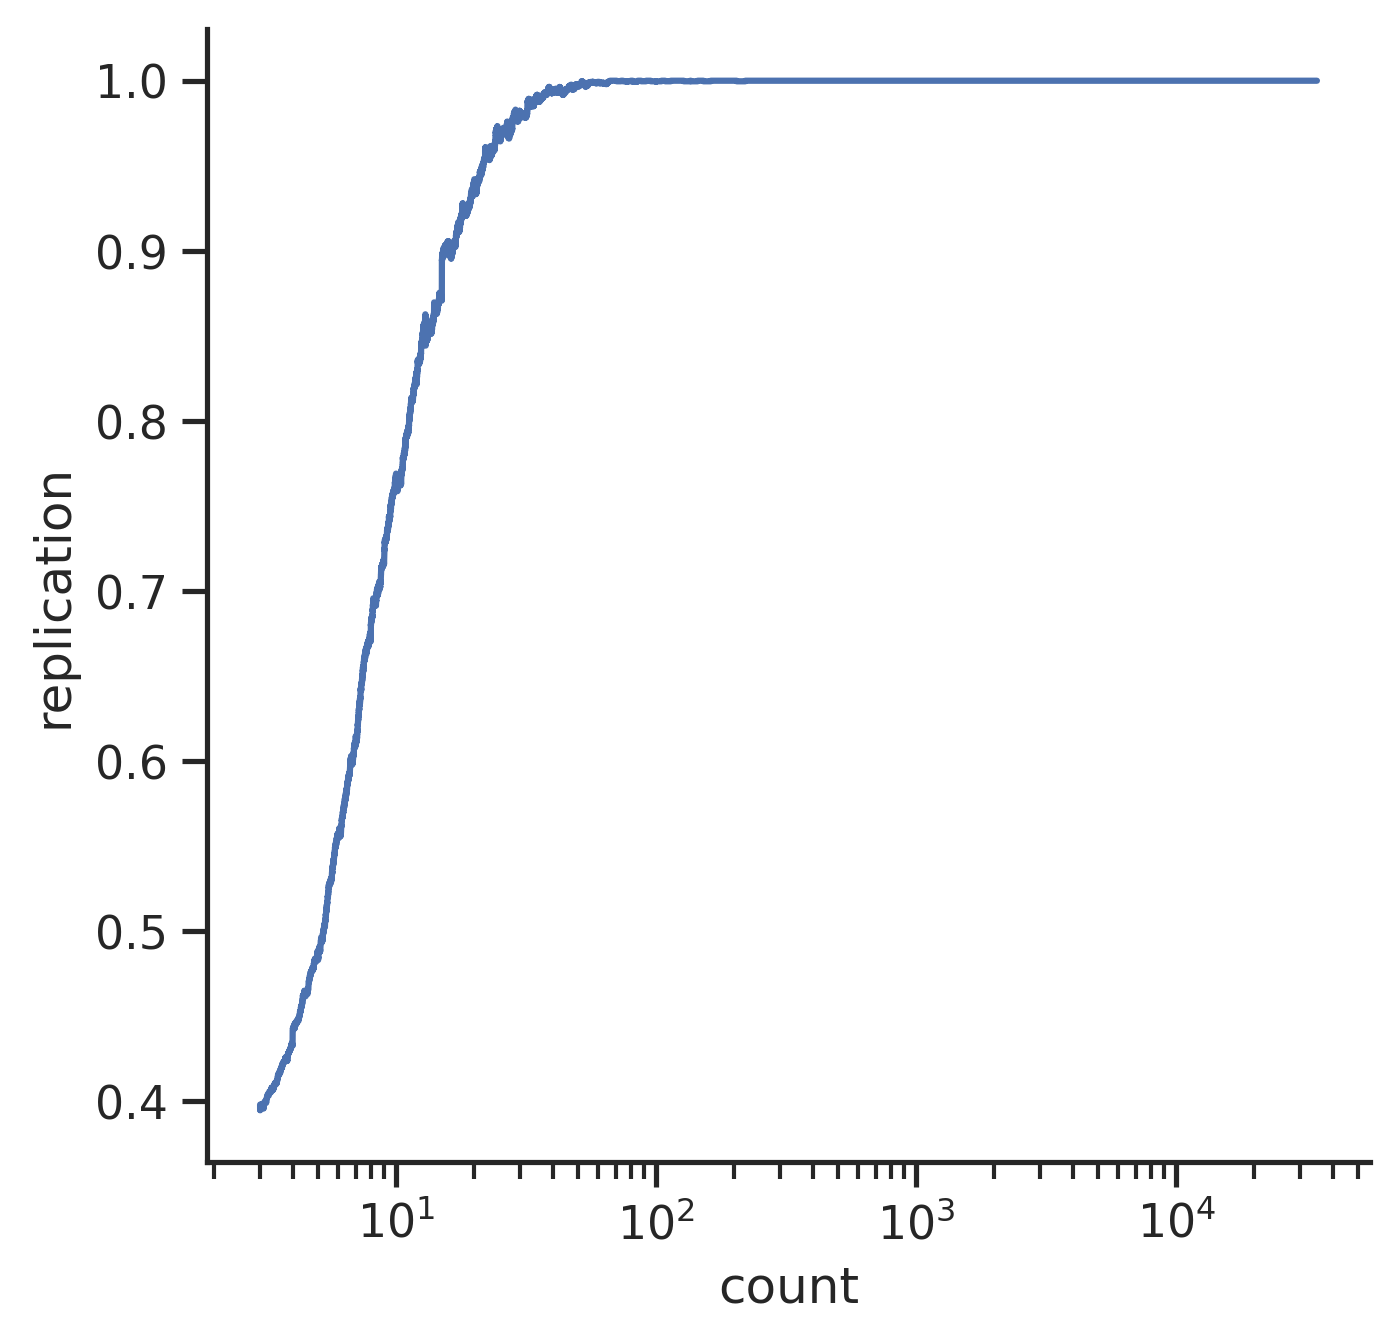

In [169]:
plt.figure(figsize=(5, 5), dpi=300)

sns.lineplot(data=df, x='count', y='replication')
plt.xscale('log')

In [170]:
df['rank'] = df['count'].rank(ascending=False)

In [171]:
?pd.Series.rank

<AxesSubplot:xlabel='rank', ylabel='replication'>

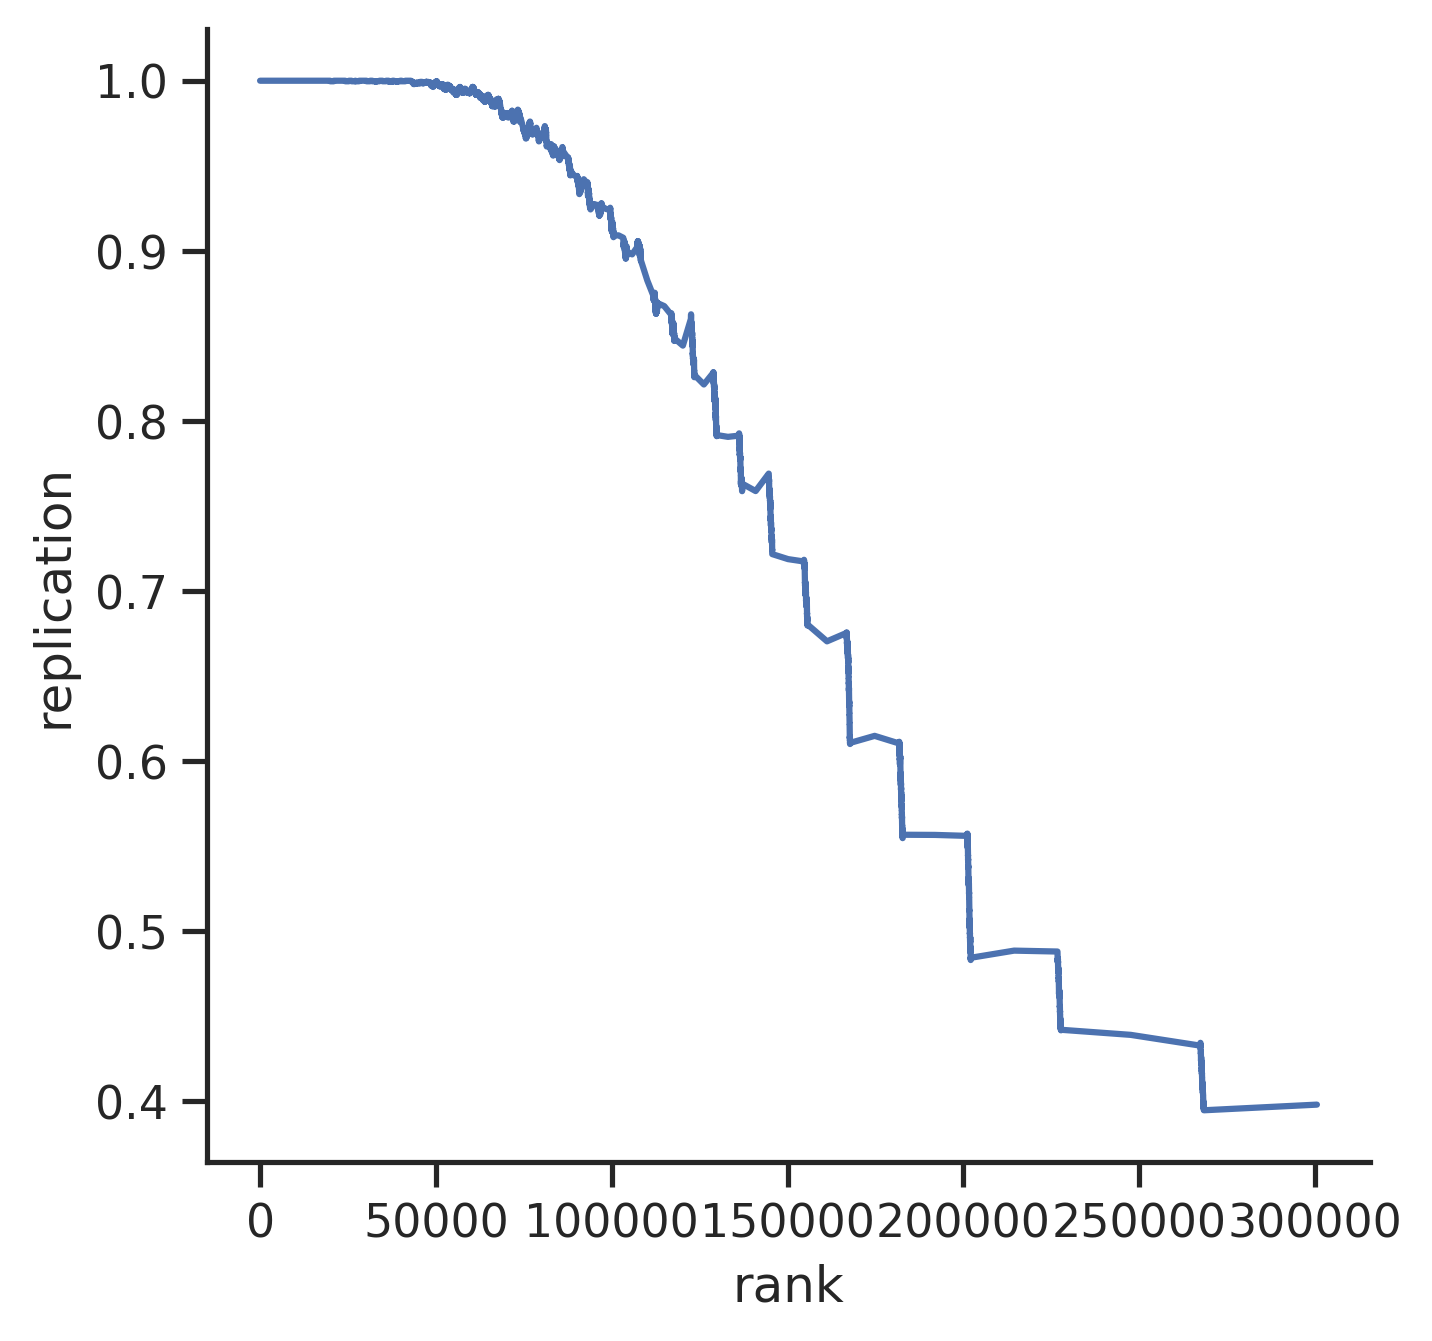

In [172]:
plt.figure(figsize=(5, 5), dpi=300)

sns.lineplot(data=df, x='rank', y='replication')
#plt.xscale('log')

In [174]:
df[df['replication'] > 0.95]

,replication,count,rank
polya_site,,,
chrX:103252995:-,1.000000,34774.271,1.0
chr8:144423616:-,1.000000,33358.259,2.0
chr9:110244019:-,1.000000,32120.905,3.0
chr5:133971915:-,1.000000,31404.905,4.0
chr16:11837353:-,1.000000,30772.679,5.0
...,...,...,...
chr2:241328574:+,0.951000,21.538,87962.0
chr1:10461083:-,0.951000,21.537,87963.0
chr2:121671728:+,0.950667,21.536,87964.0


In [177]:
result_quantseq = LapaResult(snakemake.input['quantseq'][0], tpm_cutoff=1)


In [178]:
result_quantseq.counts().min()

ENCFF399HRH    21.0
ENCFF364WSF    23.0
ENCFF146APZ    28.0
dtype: float64

In [163]:
result_quantseq.counts()[(result_quantseq.attribute('usage') > 0.05).all(axis=1)]

,ENCFF399HRH,ENCFF364WSF,ENCFF146APZ
polya_site,,,
chr10:100150094:-,482.0,539.0,532.0
chr10:100188367:-,59.0,114.0,95.0
chr10:100232297:-,316.0,352.0,430.0
chr10:100232412:-,61.0,60.0,60.0
chr10:100274700:-,2497.0,2426.0,2207.0
...,...,...,...
chrY:19605814:+,316.0,342.0,351.0
chrY:19705419:-,159.0,257.0,260.0
chrY:20592629:+,231.0,213.0,487.0


In [77]:
result_quantseq.counts()

,ENCFF399HRH,ENCFF364WSF,ENCFF146APZ
polya_site,,,
chr10:100150094:-,482.0,539.0,532.0
chr10:100188367:-,59.0,114.0,95.0
chr10:100189848:-,NaN,NaN,73.0
chr10:100196405:-,NaN,NaN,58.0
chr10:100232297:-,316.0,352.0,430.0
...,...,...,...
chrY:5006623:+,55.0,NaN,85.0
chrY:5100275:+,76.0,85.0,NaN
chrY:5113100:+,75.0,87.0,NaN


In [94]:
usage = (result_quantseq.attribute('usage').loc[df_quantseq.index] > 0.05).all(axis=1)

df_quantseq.loc[usage[usage].index]

,Chromosome,Start,End,polyA_site,tpm,Strand,Feature,count,fracA,signal,canonical_site
polya_site,,,,,,,,,,,
chr10:100150094:-,chr10,100150089,100150094,100150094,21.535866,-,three_prime_utr,1553,2,100150129@AATAAA,100150093
chr10:100188367:-,chr10,100188364,100188368,100188367,3.716428,-,three_prime_utr,268,2,100188405@ATTAAA,100188299
chr10:100232297:-,chr10,100232290,100232304,100232297,14.616100,-,three_prime_utr,1054,3,100232322@AATGAA,100232297
chr10:100232412:-,chr10,100232398,100232412,100232412,2.426772,-,three_prime_utr,175,2,100232441@AATAAA,100232297
chr10:100274700:-,chr10,100274691,100274705,100274700,98.610137,-,three_prime_utr,7111,2,100274731@AATAAA,100273279
...,...,...,...,...,...,...,...,...,...,...,...
chrY:19605814:+,chrY,19605810,19605818,19605814,13.520585,+,exon,975,2,19605849@ATTAAA,-1
chrY:19705419:-,chrY,19705412,19705424,19705419,9.027591,-,three_prime_utr,651,5,19705444@AATAAA,19703864
chrY:20592629:+,chrY,20592627,20592692,20592629,12.882691,+,three_prime_utr,929,5,20592657@AATAAA,20593154


In [197]:
#result_quantseq = LapaResult(snakemake.input['quantseq'][0], tpm_cutoff=1)
#replicated = (result_quantseq.counts() > 0).all(axis=1)

df_quantseq = LapaResult(snakemake.input['quantseq'][0], tpm_cutoff=2) \
    .read_cluster(filter_internal_priming=False).drop_duplicates(core_cols)

# df_quantseq = df_quantseq.loc[replicated[replicated].index]
#df_quantseq = df_quantseq[df_quantseq['signal'] != 'None@None']

#usage = (result_quantseq.attribute('usage').loc[df_quantseq.index] > 0.01).all(axis=1)

#df_quantseq = df_quantseq.loc[usage[usage].index]
df_quantseq = df_quantseq[df_quantseq['signal'].str.endswith('@AATAAA')]

gr_quantseq = pr.PyRanges(df_quantseq, int64=True)

In [198]:
df_quantseq.shape

(13173, 11)

In [199]:
def join_outer(gr1, gr2, suffix):
    return gr1.join(gr2, strandedness='same', how='outer', suffix=suffix)

In [200]:
results_benchmark = dict()

for k, result in tqdm(results.items()):  
    df = result.read_cluster().drop_duplicates(core_cols)

    #df = df[df['signal'] != 'None@None']
    
    df = df[df['signal'].str.endswith('@AATAAA')]
    gr =  pr.PyRanges(df, int64=True)
    df = join_outer(gr_quantseq, gr, f'_{k}').df

    results_benchmark[k] = df

  0%|                                                                                                                                                                                                                                                                 | 0/6 [00:00<?, ?it/s]/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = 

/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/

/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/

 17%|█████████████████████████████████████████▌                                                                                                                                                                                                               | 1/6 [00:03<00:16,  3.34s/it]/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = 

/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/

/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/

 33%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                      | 2/6 [00:06<00:11,  2.95s/it]/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = 

/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/

/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 3/6 [00:08<00:08,  2.84s/it]/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = 

/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/

/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 4/6 [00:11<00:05,  2.76s/it]/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = 

/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/

/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/

/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/

/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/

/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/

/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/cs/anaconda3/envs/

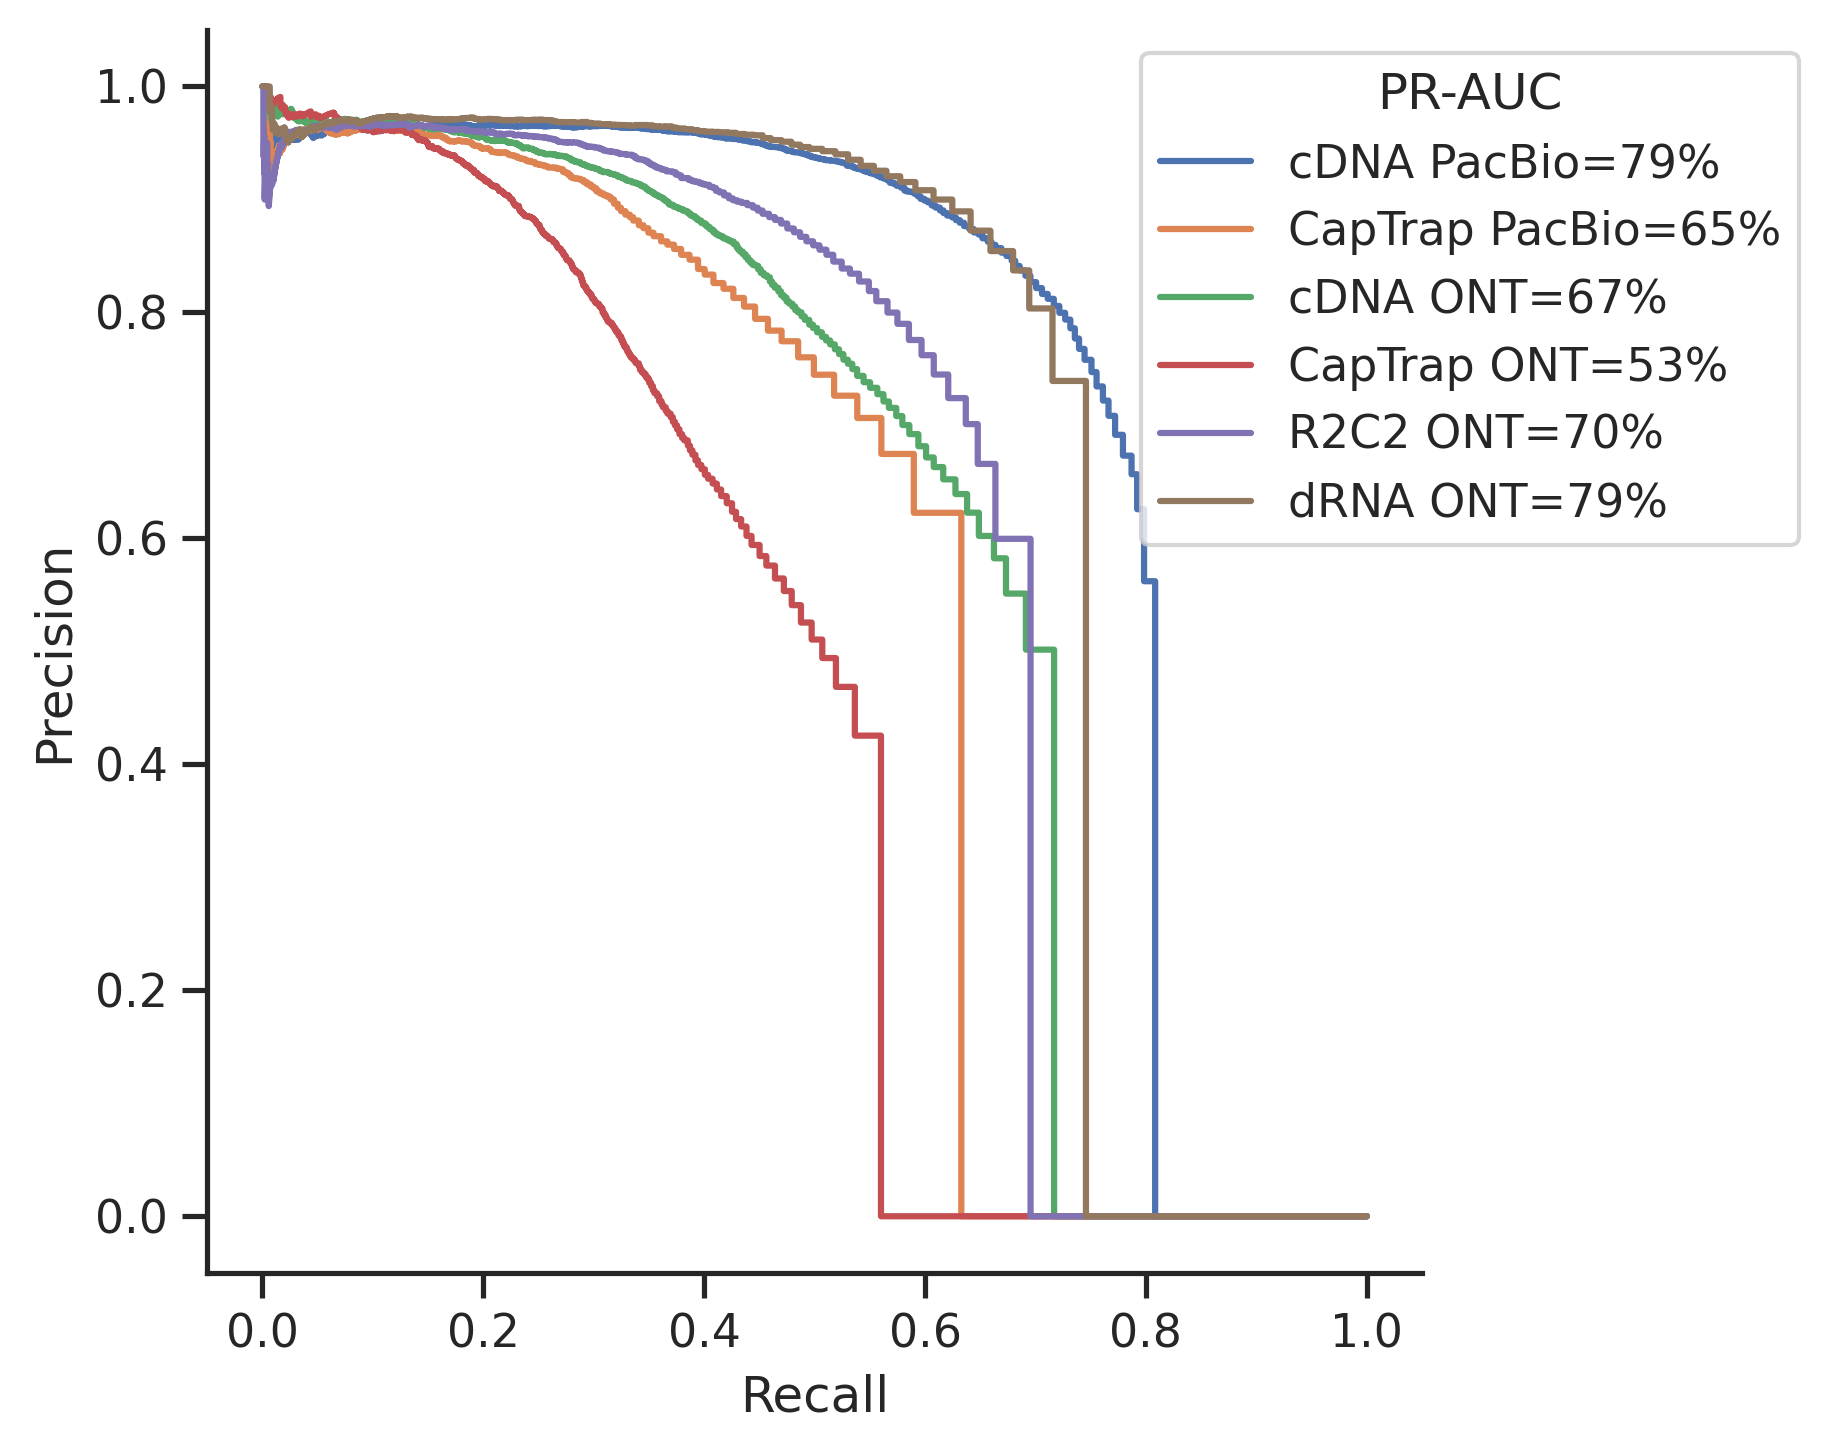

In [201]:
plt.figure(figsize=(5, 5), dpi=300)

from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

df_benchmark = list()

for label, df in results_benchmark.items():    
    ground_truth = list((df['polyA_site'] != -1).astype(int))
    score = df[f'tpm_{label}'].replace(-1, 0)

    prec, recall, threshold = precision_recall_curve(
        ground_truth, score, pos_label=1)
    prec[0] = 0

    df_benchmark.append(pd.DataFrame({
        'data source': f'{label}={int(auc(recall, prec) * 100)}%',
        'Precision': prec,
        'Recall': recall
    }))
    
df_benchmark = pd.concat(df_benchmark).reset_index(drop=True)
    
sns.lineplot(data=df_benchmark, y='Precision', x='Recall', 
             hue='data source', 
             drawstyle='steps-pre')

plt.legend()._legend_box.align='right'

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.tight_layout()
plt.legend(bbox_to_anchor=(0.75, 1.), loc='upper left', title='PR-AUC')

plt.savefig(snakemake.output['pr_curve_plot'], bbox_inches = "tight")

In [203]:
from collections import defaultdict

df_overlap = pd.DataFrame({})

paths = [
    snakemake.input['quantseq'][0],
    *snakemake.input['lapa_dir']
]

for i in tqdm(paths):
    
    result_i = LapaResult(i, tpm_cutoff=0)
    gr_i =  pr.PyRanges(result_i.read_cluster(), int64=True)
    gr_i = gr_i[gr_i.tpm > 2]
    gr_i = gr_i[gr_i.signal.str.endswith('@AATAAA')]
    
    library_prep, platform, _ = Path(i).name.split('_')
    name_i = f'{library_prep} {platform}'.replace('quantseq Illumina', 'Quantseq3')

    for j in paths:
        result_j = LapaResult(j, tpm_cutoff=0)
        gr_j =  pr.PyRanges(result_j.read_cluster(), int64=True)

        gr_j = gr_j[gr_j.signal != 'None@None']

        library_prep, platform, _ = Path(j).name.split('_')
        name_j = f'{library_prep} {platform}'.replace('quantseq Illumina', 'Quantseq3')

        df = gr_i.nearest(gr_j, strandedness='same', suffix=f'_{j}').df
        
        df = df[df['Distance'] < 1]

        df_overlap.loc[name_i, name_j] = df.shape[0] / gr_i.df.shape[0]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:18<00:00, 11.27s/it]


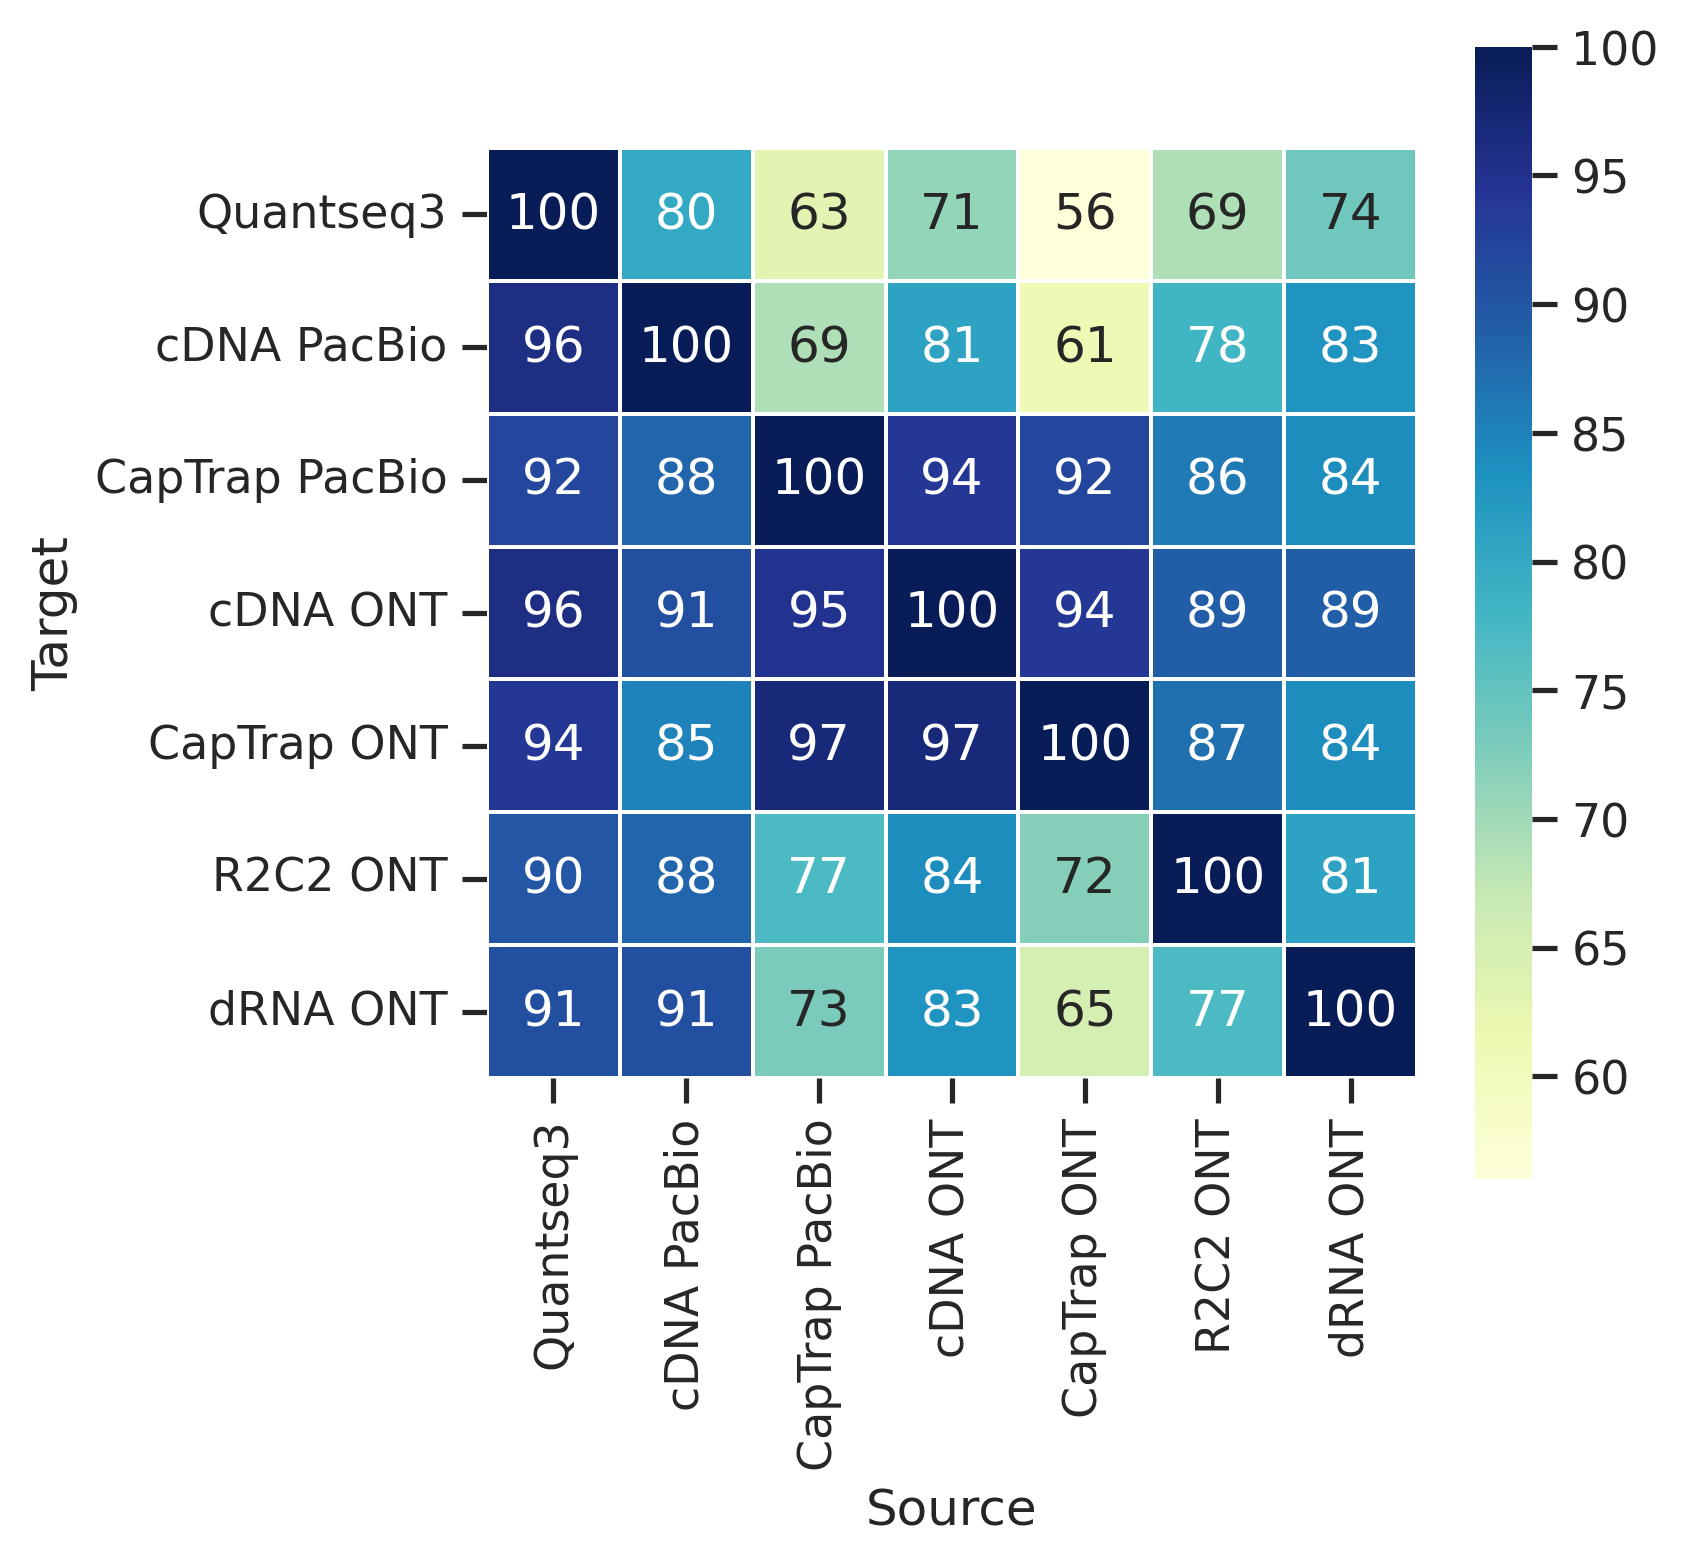

In [204]:
plt.figure(dpi=300, figsize=(5, 5))

sns.heatmap((df_overlap * 100).astype(int), annot=True, square=True,
            fmt="d", linewidths=.5, cmap="YlGnBu")
plt.xlabel('Source')
plt.ylabel('Target')
plt.savefig(snakemake.output['heatmap'], bbox_inches = "tight")